# Project 3: Poisonous Mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 examples, where each describes a mushroom by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. The feature space has been binarized. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using k-means and density estimation with Gaussian mixture models (GMM). Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please **prepare your own write-up and write your own code**.

In [1]:
%matplotlib inline

import urllib.request as urllib2 # For python3
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

# added imports
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
MUSHROOM_DATA = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.data'
MUSHROOM_MAP = 'https://raw.githubusercontent.com/UCB-MIDS/207-Applied-Machine-Learning/master/Data/mushroom.map'

Load feature names.

In [3]:
feature_names = []

for line in urllib2.urlopen(MUSHROOM_MAP):
    [index, name, junk] = line.decode('utf-8').split()
    feature_names.append(name)

print('Loaded feature names: ', len(feature_names))
print(feature_names)

Loaded feature names:  126
['cap-shape=bell', 'cap-shape=conical', 'cap-shape=convex', 'cap-shape=flat', 'cap-shape=knobbed', 'cap-shape=sunken', 'cap-surface=fibrous', 'cap-surface=grooves', 'cap-surface=scaly', 'cap-surface=smooth', 'cap-color=brown', 'cap-color=buff', 'cap-color=cinnamon', 'cap-color=gray', 'cap-color=green', 'cap-color=pink', 'cap-color=purple', 'cap-color=red', 'cap-color=white', 'cap-color=yellow', 'bruises?=bruises', 'bruises?=no', 'odor=almond', 'odor=anise', 'odor=creosote', 'odor=fishy', 'odor=foul', 'odor=musty', 'odor=none', 'odor=pungent', 'odor=spicy', 'gill-attachment=attached', 'gill-attachment=descending', 'gill-attachment=free', 'gill-attachment=notched', 'gill-spacing=close', 'gill-spacing=crowded', 'gill-spacing=distant', 'gill-size=broad', 'gill-size=narrow', 'gill-color=black', 'gill-color=brown', 'gill-color=buff', 'gill-color=chocolate', 'gill-color=gray', 'gill-color=green', 'gill-color=orange', 'gill-color=pink', 'gill-color=purple', 'gill-col

Load data. The dataset is sparse, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

for line in urllib2.urlopen(MUSHROOM_DATA):
    items = line.decode('utf-8').split()
    Y.append(int(items.pop(0)))
    x = np.zeros(len(feature_names))
    for item in items:
        feature = int(str(item).split(':')[0])
        x[feature] = 1
    X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


### Part 1:

Do a principal components analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].  Also show a lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.

Notes:
* You can use `PCA` to produce a PCA analysis.

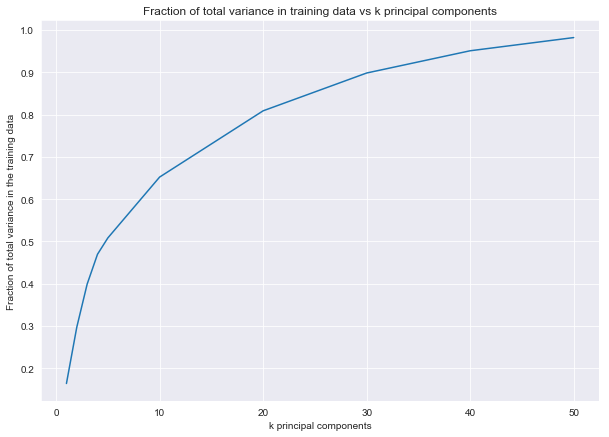

In [5]:
def P1():

## STUDENT START ###
    k_list = [1,2,3,4,5,10,20,30,40,50]
    variance_list = []
    for k in k_list:
        # producing principal components analysis
        pca = PCA(n_components=k)
        pca.fit(train_data)
        tot_variance = sum(pca.explained_variance_ratio_)
        variance_list.append(tot_variance) # is this the same as the fraction of the total variance
    
    # plotting fraction of total variance vs num of principal components
    plt.figure(figsize=(10,7))
    sns.lineplot(k_list, variance_list)
    plt.xlabel('k principal components')
    plt.ylabel('Fraction of total variance in the training data')
    plt.title('Fraction of total variance in training data vs k principal components')
    plt.show()
## STUDENT END ###

P1()

### Part 2:

PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and show as a square scatterplot. Show the positive (poisonous) examples in red and the negative (non-poisonous) examples in green. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

Notes:
* You can use `PCA` to produce a PCA analysis.

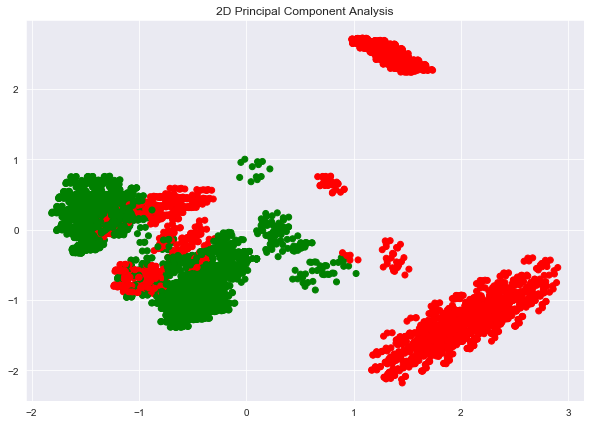

In [6]:
def P2():

## STUDENT START ###

    # producing principal component analysis
    pca = PCA(n_components=2)
    components = pca.fit_transform(train_data)
    # setting data labels to corresponding color (red = poisonous, green = non-poisonous)
    y = np.choose(train_labels, ['g', 'r'])
    # plotting 2D PCA
    plt.figure(figsize=(10,7))
    plt.scatter(components.T[0],components.T[1], c=y)
    plt.title('2D Principal Component Analysis')
    plt.show()

## STUDENT END ###

P2()

### Part 3:

Fit a k-means cluster model with 6 clusters over the 2d projected data. As in part 2, show as a square scatterplot with the positive (poisonous) examples in red and the negative (non-poisonous) examples in green.  For each cluster, mark the centroid and plot a circle that goes through the cluster's example that is most distant from the centroid.

Notes:
* You can use `KMeans` to produce a k-means cluster analysis.
* You can use `linalg.norm` to determine distance (dissimilarity) between observations.

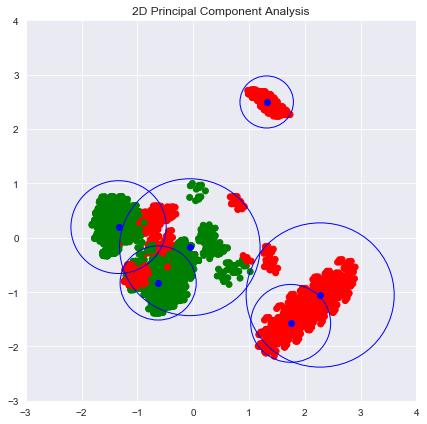

In [7]:
def P3():

## STUDENT START ###

    # producing principal component analysis
    pca = PCA(n_components=2)
    components = pca.fit_transform(train_data)
    # fitting a k-means cluster model with 6 clusters over the 2d projected data
    kmeans = KMeans(n_clusters = 6, random_state=0)
    kmeans.fit(components)
    y_pred = kmeans.predict(components)

    # getting cluster radii with the help of 
    # https://datascience.stackexchange.com/questions/32753/find-cluster-diameter-and-associated-cluster-points-with-kmeans-clustering-scik
    clusters_centroids=dict()
    clusters_radii= dict()
    centers = kmeans.cluster_centers_

    # calculating Euclidean distance of each point within clusters from centroid and picking maximum as radius
    for cluster in list(set(y_pred)):
        clusters_centroids[cluster]=list(zip(centers[:, 0],centers[:,1]))[cluster]
        clusters_radii[cluster] = max([np.linalg.norm(np.subtract(i,clusters_centroids[cluster])) 
                                       for i in zip(components[y_pred == cluster, 0],components[y_pred == cluster, 1])])

    centers = kmeans.cluster_centers_
    # setting data labels to corresponding color (red = poisonous, green = non-poisonous)
    y = np.choose(train_labels, ['g', 'r'])

    # plotting 2D PCA
    plt.figure(figsize=(7,7))
    plt.scatter(components.T[0],components.T[1], c=y)
    plt.scatter(centers.T[0], centers.T[1], c='b')
    for i in range(6):
        circle = plt.Circle((clusters_centroids[i]), clusters_radii[i], edgecolor='b',fill=False)
        plt.gcf().gca().add_artist(circle)
    plt.title('2D Principal Component Analysis')
    plt.xlim((-3, 4))
    plt.ylim((-3, 4))
    plt.show()
    
    
## STUDENT END ###

P3()

### Part 4:

Fit Gaussian mixture models for the positive (poisonous) examples in your 2d projected data. Vary the number of mixture components from 1 to 4 and the covariance matrix type 'spherical', 'diag', 'tied', 'full' (that's 16 models).  Show square plots of the estimated density contours presented in a 4x4 grid - one row each for a number of mixture components and one column each for a convariance matrix type.  

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `contour` in combination with other methods to plot contours, like in this example: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
* You can use `contour` without the `norm` and `levels` parameters. 

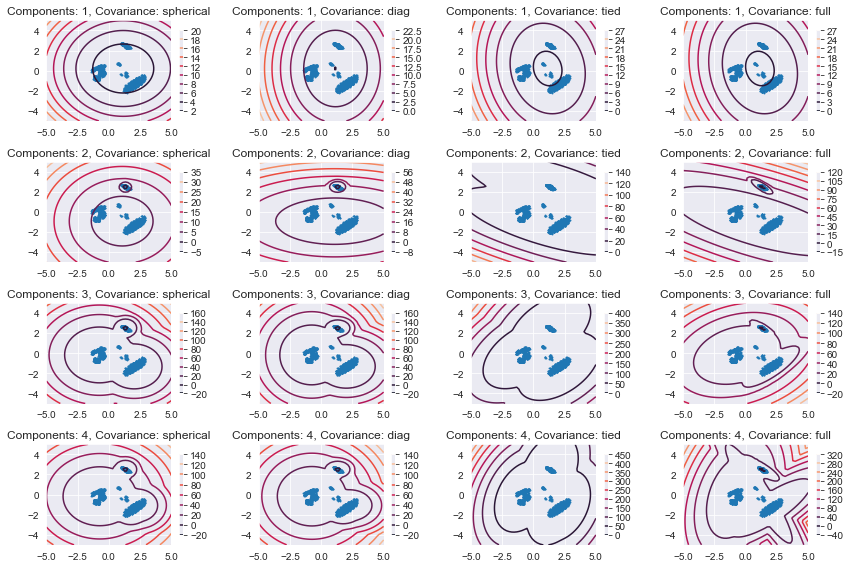

In [8]:
def P4():

## STUDENT START ###

    # producing principal component analysis
    pca = PCA(n_components=2)
    components = pca.fit_transform(train_data)

    # getting only positive (poisonous) examples in the 2d projected data
    pos_components = components[train_labels==1]

    n_list = [1,2,3,4]
    type_list = ['spherical', 'diag', 'tied', 'full']

    fig, ax = plt.subplots(4,4, figsize=(12,8))

    for n in range(len(n_list)):
        for t in range(len(type_list)):

            # fitting gaussian mixture models for the positive examples in 2d projected data
            gmm = GaussianMixture(n_components=n_list[n], covariance_type=type_list[t], random_state=12345)
            gmm.fit(pos_components)

            # display predicted scores by the model as a contour plot
            x = np.linspace(-5,5)
            y = np.linspace(-5,5)
            X, Y = np.meshgrid(x,y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gmm.score_samples(XX)
            Z = Z.reshape(X.shape)

            CS = ax[n,t].contour(X, Y, Z)
            CB = fig.colorbar(CS, ax=ax[n,t],shrink=0.8, extend='both')
            ax[n,t].scatter(pos_components[:, 0], pos_components[:, 1], .8)
            ax[n,t].set_title(f'Components: {n_list[n]}, Covariance: {type_list[t]}')

    plt.tight_layout()
    plt.show()

## STUDENT END ###

P4()

### Part 5:

Fit two Gaussian mixture models, one for the positive examples and one for the negative examples in your 2d projected data. Use 4 mixture components and full convariance for each model.  Predict the test example labels by picking the labels corresponding to the larger of the two models' probabilities.  What is the accuracy of you predictions on the test data?

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.
* You can use `GaussianMixture`'s `score_samples` method to find the probabilities.

In [9]:
def P5():

## STUDENT START ###

    # producing principal component analysis to transform train and test data to 2d
    pca = PCA(n_components=2)
    components = pca.fit_transform(train_data)
    test_components = pca.transform(test_data)

    # getting only positive (poisonous) examples in the 2d projected data
    pos_components = components[train_labels==1]
    # getting only negative (non-poisonous) examples in the 2d projected data
    neg_components = components[train_labels==0]
    comp_list = [neg_components, pos_components]

    score_lists = []
    # fitting gaussian mixture models for the positive and negative examples in 2d projected data
    for comp in comp_list: 
        # using 4 mixture components and full convariance for each model
        gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=12345)
        gmm.fit(comp)
        score_lists.append(gmm.score_samples(test_components))

    pred = [] # predicted values indicated by which probability is larger
    for sample in np.array(score_lists).T: # 0th index is negative, first index is positive
        pred.append(np.argmax(sample))

    accuracy = accuracy_score(test_labels, pred)
    print(f'Accuracy of my predictions on the test data: {accuracy}')

## STUDENT END ###

P5()

Accuracy of my predictions on the test data: 0.9501779359430605


### Part 6:

Run a series of experiments to find the Gaussian mixture model that results in the best accuracy with no more than 50 parameters.  Do this by varying the number of PCA components, the number of GMM components, and the covariance type.

Notes:
* You can use `GaussianMixture(n_components=..., covariance_type=..., random_state=12345)` to produce a Gaussian mixture model.


* For spherical, diag, and full covariance types:
  * number of parameters = (number of parameters per gmm component * number of gmm components - 1) * number of classes
  * number of parameters per gmm component includes all the means plus all the non-zero, non-duplicated values in the covariance matrix plus the mixing weight
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter


* To calculate the number of parameters for tied covariance type:
  * number of parameters = (number of parameters per class - 1) * number of classes
  * number of parameters per class includes all the means and mixing weights for all the gmm components plus all the non-zero, non-duplicated values in the one shared covariance matrix
  * Each mixing weight parameter indicates how much to weight a particular gmm component; the -1 above accounts for the fact that the mixing weights must sum to 1, so you do not need to include the last mixing weight as its own parameter

In [10]:
def gmm_accuracy(n_pca, n_gmm, t):
    # producing principal component analysis to transform train and test data to 2d
    pca = PCA(n_components=n_pca)
    components = pca.fit_transform(train_data)
    test_components = pca.transform(test_data)

    # getting only positive (poisonous) examples in the 2d projected data
    pos_components = components[train_labels==1]
    # getting only negative (non-poisonous) examples in the 2d projected data
    neg_components = components[train_labels==0]
    comp_list = [neg_components, pos_components]

    score_lists = []
    # fitting gaussian mixture models for the positive and negative examples in 2d projected data
    for comp in comp_list: 
        # using 4 mixture components and full convariance for each model
        gmm = GaussianMixture(n_components=n_gmm, covariance_type=t, random_state=12345)
        gmm.fit(comp)
        score_lists.append(gmm.score_samples(test_components))

    pred = [] # predicted values indicated by which probability is larger
    for sample in np.array(score_lists).T: # 0th index is negative, first index is positive
        pred.append(np.argmax(sample))

    accuracy = accuracy_score(test_labels, pred)
    return accuracy

In [11]:
def P6():

## STUDENT START ###

    # setting parameters to loop through
    n_class = 2
    n_pca_list = [1, 2, 3, 4, 5, 10, 20, 30, 40, 50] # same list as P1
    n_gmm_list = [1,2,3,4,5] 
    type_list = ['spherical', 'diag', 'tied', 'full']
    
    # creating empty variables to fill 
    max_accuracy = 0
    best_pca = 0
    best_gmm = 0
    best_type = 0
    
    # looping through different iterations 
    # n_comp = number of parameters using Amit's very helpful google sheet
    # https://docs.google.com/spreadsheets/d/1nzKvjJVOmyKHIAPYaEfGcnGEMxLL0LU6b9InZ32J82E/edit?usp=sharing
    for n_pca in n_pca_list:
        for n_gmm in n_gmm_list:
            for t in type_list:
                if t == 'full':
                    n_comp = (n_pca*n_gmm + n_pca * (n_pca + 1)/ 2 * n_gmm) * n_class
                    if n_comp < 50: # we only want less than 50 parameters
                        if gmm_accuracy(n_pca,n_gmm,t) > max_accuracy:
                            max_accuracy,best_pca,best_gmm,best_type = gmm_accuracy(n_pca,n_gmm,t),n_pca,n_gmm,t
                elif t == 'diag':
                    n_comp = (n_pca*n_gmm + n_pca * n_gmm) * n_class
                    if n_comp < 50:
                        if gmm_accuracy(n_pca,n_gmm,t) > max_accuracy:
                            max_accuracy,best_pca,best_gmm,best_type = gmm_accuracy(n_pca,n_gmm,t),n_pca,n_gmm,t
                elif t == 'spherical':
                    n_comp = (n_pca*n_gmm + n_gmm) * n_class
                    if n_comp < 50:
                        if gmm_accuracy(n_pca,n_gmm,t) > max_accuracy:
                            max_accuracy,best_pca,best_gmm,best_type = gmm_accuracy(n_pca,n_gmm,t),n_pca,n_gmm,t
                else:
                    n_comp = (n_pca*n_gmm + n_pca * (n_pca + 1)/ 2) * n_class
                    if n_comp < 50:
                        if gmm_accuracy(n_pca,n_gmm,t) > max_accuracy:
                            max_accuracy,best_pca,best_gmm,best_type = gmm_accuracy(n_pca,n_gmm,t),n_pca,n_gmm,t

    print("Model with Best Accuracy")
    print(f"Type: {best_type}, PCA components: {best_pca}, GMM components: {best_gmm}")
    print(f"Accuracy:{max_accuracy}")

## STUDENT END ###

P6()

Model with Best Accuracy
Type: tied, PCA components: 4, GMM components: 3
Accuracy:0.9697508896797153
